In [1]:
import os
import re
import sys
from collections import Counter
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import FrenchStemmer
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.stats import spearmanr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# Local application imports
sys.path.insert(0, '../Utility files')
import utils2
from utils2 import *
from model_comparison import CrossValidation


### General overview

In [2]:
#Load all user coordinates
user_coords = utils2.load_all_row_coords_files(9)

# Load the coordinate files for models 1 to 9
job_coords = utils2.load_CA_model_files(9)

#Load the marker coords
marker_coords = utils2.load_all_column_coords_files(9)


Used file path: /home/livtollanes/NewData/coordinates/m1_coords/m1_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m2_coords/m2_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m3_coords/m3_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m4_coords/m4_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m5_coords/m5_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m6_coords/m6_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m7_coords/m7_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m8_coords/m8_row_coordinates.csv
Used file path: /home/livtollanes/NewData/coordinates/m9_coords/m9_row_coordinates.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m1_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m2_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job

In [12]:
#Coordinate ranges
for i in range(2):
    min_val_user = user_coords[i]['0'].min()
    max_val_user = user_coords[i]['0'].max()
    min_val_marker = marker_coords[i]['0'].min()
    max_val_marker = marker_coords[i]['0'].max()

    print(f"For Df{i+1}:")
    print(f"Coordinate ranges in dim0 for Users: {min_val_user}, {max_val_user}")
    print(f"Coordinate ranges in dim0 for Markers: {min_val_marker}, {max_val_marker}")
    print("\n")

dfs = [marker_coords[0], marker_coords[2], marker_coords[6]]

For Df1:
Coordinate ranges in dim0 for Users: -1.857363747620658, 2.373286995730377
Coordinate ranges in dim0 for Markers: -1.4740972213055, 1.8887795369498348


For Df2:
Coordinate ranges in dim0 for Users: -2.196695399016296, 2.0237896424507795
Coordinate ranges in dim0 for Markers: -1.7640850325575554, 1.588087699932512




### General distribution - markers and users

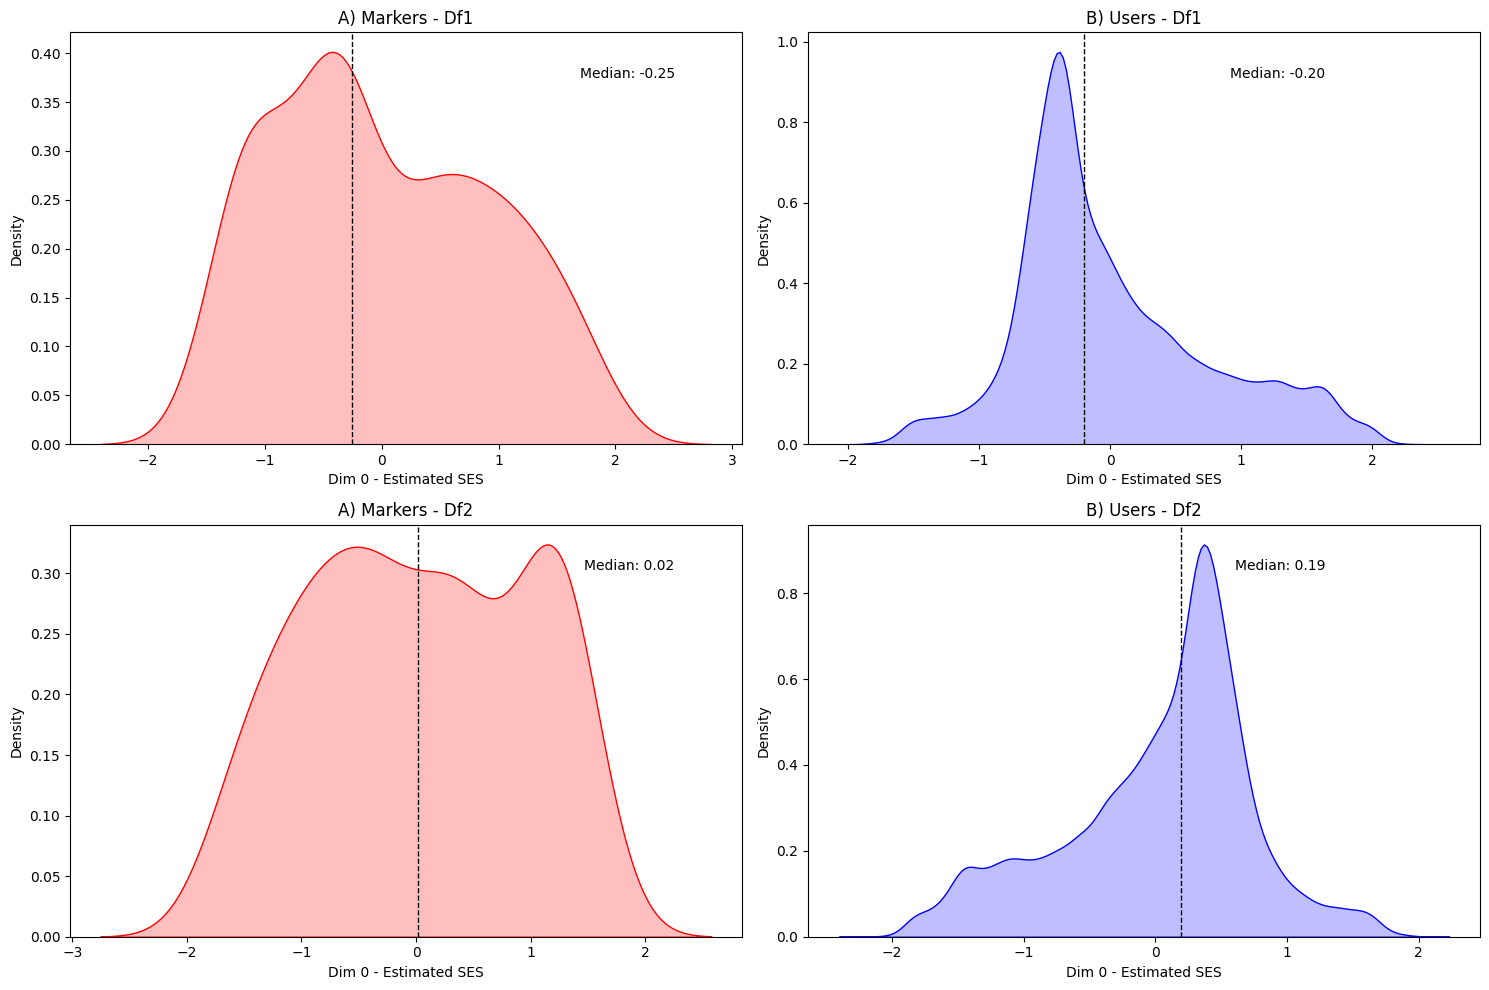

In [26]:

#Kernal density estimate plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i in range(2):
    # Plot the density of '0' for marker_coords[i]
    data = marker_coords[i]['0']
    sns.kdeplot(data, ax=axs[i, 0], color='red', fill=True)
    axs[i, 0].set_xlabel('Dim 0 - Estimated SES')
    axs[i, 0].set_ylabel('Density')
    axs[i, 0].set_title(f'A) Markers - Df{i + 1}')
    
    # Add a vertical line for the median of marker_coords[i]
    median_marker = np.median(data)
    axs[i, 0].axvline(median_marker, color='black', linestyle='dashed', linewidth=1)
    axs[i, 0].text(0.9, 0.9, f'Median: {median_marker:.2f}', horizontalalignment='right', verticalalignment='center', transform=axs[i, 0].transAxes)
    # Plot the density of '0' for user_coords[i]
    data = user_coords[i]['0']
    sns.kdeplot(data, ax=axs[i, 1], color='blue', fill=True)
    axs[i, 1].set_xlabel('Dim 0 - Estimated SES')
    axs[i, 1].set_ylabel('Density')
    axs[i, 1].set_title(f'B) Users - Df{i+1}')
    
    # Add a vertical line for the median of user_coords[i]
    median_user = np.median(data)
    axs[i, 1].axvline(median_user, color='black', linestyle='dashed', linewidth=1)
    axs[i, 1].text(0.77, 0.9, f'Median: {median_user:.2f}', horizontalalignment='right', verticalalignment='center', transform=axs[i, 1].transAxes)
plt.tight_layout()
plt.show()


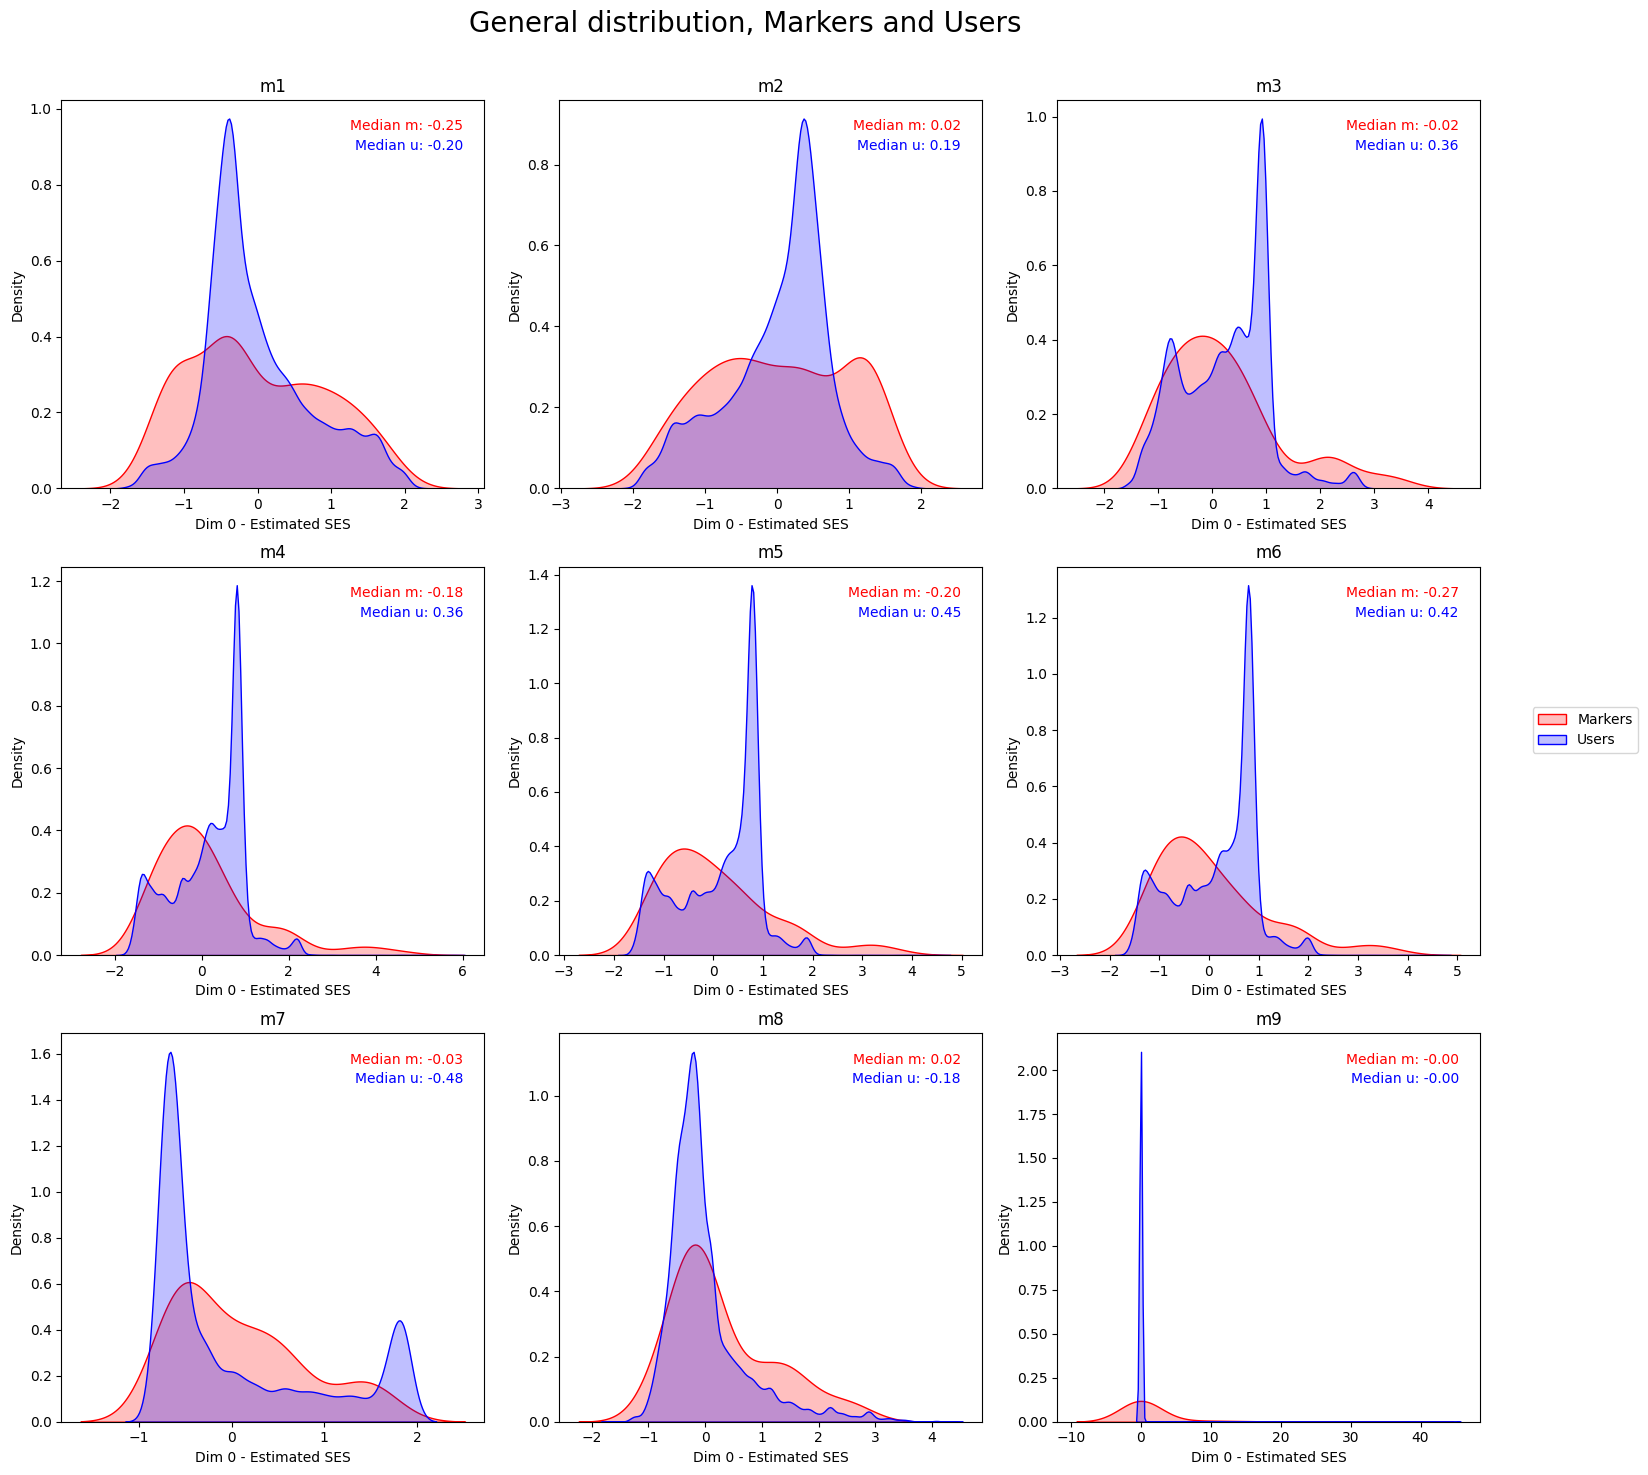

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('General distribution, Markers and Users', fontsize=20)

# Flatten the axes array to loop over it
axs = axs.flatten()

# Loop over each DataFrame in marker_coords
for i in range(len(marker_coords)):
    # Plot the density of '0' for marker_coords[i]
    sns.kdeplot(marker_coords[i]['0'], color='red', fill=True, label='Markers', ax=axs[i])

    # Plot the density of '0' for user_coords[i]
    sns.kdeplot(user_coords[i]['0'], color='blue', fill=True, label='Users', ax=axs[i])

    # Calculate medians
    median_markers = marker_coords[i]['0'].median()
    median_users = user_coords[i]['0'].median()

    # Add text to the upper right corner
    axs[i].text(0.95, 0.95, f'Median m: {median_markers:.2f}', horizontalalignment='right', verticalalignment='top', transform=axs[i].transAxes, color='red')
    axs[i].text(0.95, 0.90, f'Median u: {median_users:.2f}', horizontalalignment='right', verticalalignment='top', transform=axs[i].transAxes, color='blue')

    # Set the labels and title for the current subplot
    axs[i].set_xlabel('Dim 0 - Estimated SES')
    axs[i].set_ylabel('Density')
    axs[i].set_title(f'm{i+1}')

# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

### Qualitative marker inspection

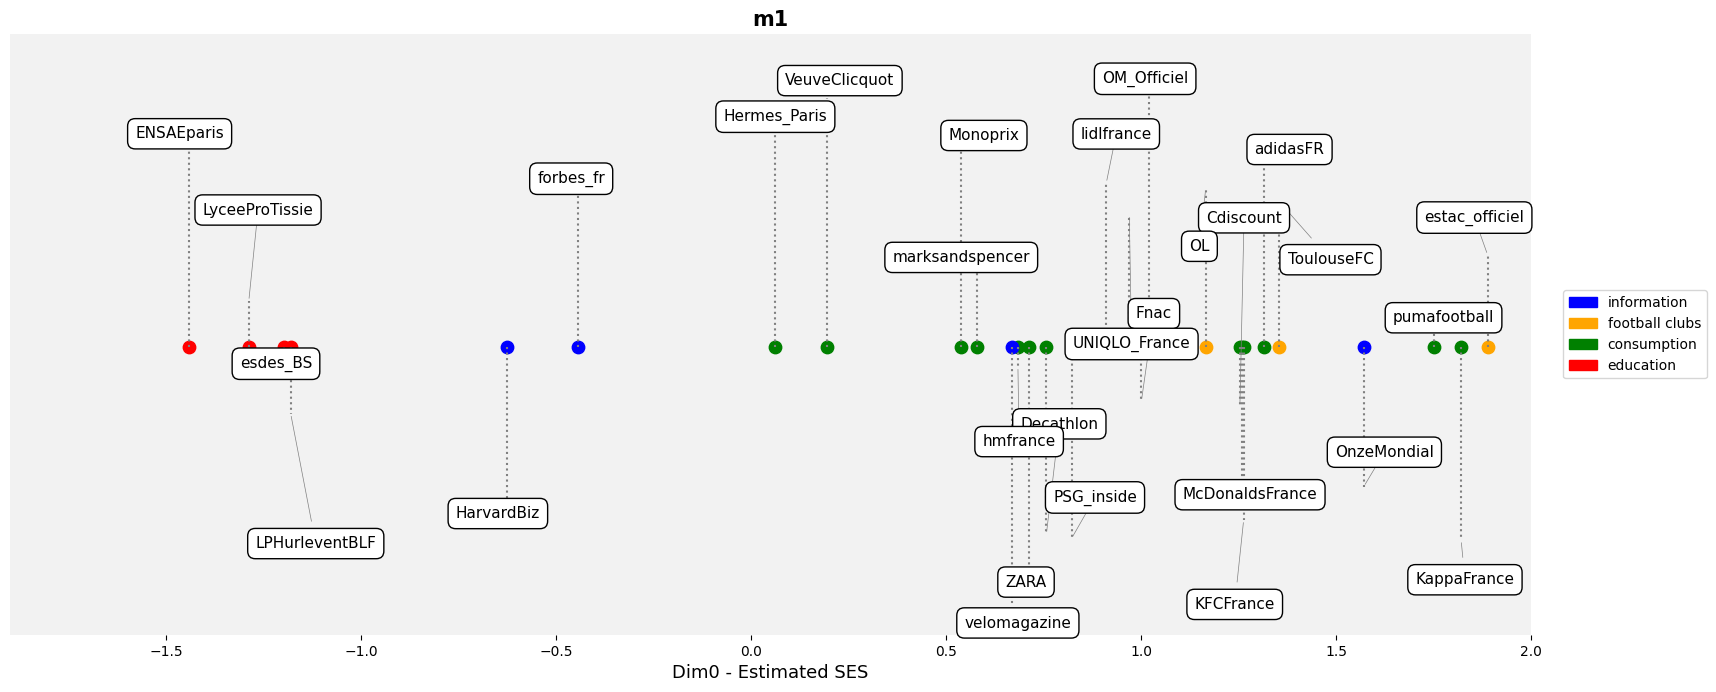

In [17]:
import matplotlib.patches as mpatches
import numpy as np
from adjustText import adjust_text
# Define the DataFrames
dfs = [marker_coords[0], marker_coords[2], marker_coords[6]]
# Define the color dictionary for 'type'
color_dict = {'information': 'blue', 'football clubs': 'orange', 'consumption': 'green', 'education': 'red'}
# Define the list of twitter_names to include
twitter_names = ['estac_officiel', 'KappaFrance', 'pumafootball', 'OnzeMondial', 'ToulouseFC', 'OnzeMondial', 'KFCFrance', 'McDonaldsFrance', 'Cdiscount', 'OM_Officiel', 'PSG_inside', 'adidasFR', 'OL', 'Fnac', 'UNIQLO_France', 'lidlfrance', 'ZARA', 'Decathlon', 'hmfrance', 'velomagazine', 'LyceeProTissie', 'LPHurleventBLF', 'ENSAEparis', 'HarvardBiz', 'esdes_BS', 'forbes_fr', 'Hermes_Paris', 'VeuveClicquot', 'Cdiscount', 'Fnac', 'lidlfrance', 'Monoprix', 'marksandspencer']
# Filter the DataFrames to include only the specified twitter_names
dfs = [df[df['twitter_name'].isin(twitter_names)] for df in dfs]

# Create a single plot
fig, ax = plt.subplots(figsize=(17, 7))


# Remove the outer frame
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)


# Add a very light grey background
ax.set_facecolor((0.95, 0.95, 0.95))

# Get the first DataFrame
df = dfs[0]
texts = []  # List to store all the text objects
# Add scatterplot for each 'twitter_name' in the DataFrame
for name in df['twitter_name'].unique():
    name_subset = df[df['twitter_name'] == name]
    type_color = color_dict[name_subset['type2'].iloc[0]]  # Get the color for the current 'type'
    scatter_points = ax.scatter(name_subset['0'], [0]*len(name_subset), color=type_color, s=80)  # Increase the size of the points
    # Add label to the plot with bigger text
    for x in name_subset['0']:
        y = np.random.uniform(-1, 1)  # Generate a random y-coordinate for the label
        text = ax.text(x, y, name, fontsize=11, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  # Increase the fontsize to a larger value
        ax.plot([x, x], [0, y], color='grey', linestyle='dotted')  # Draw a line from the scatter point to the label
        texts.append(text)
adjust_text(texts, 
            force_text=(0.09, 0.9), 
            force_static=(0.1, 0.2), 
            force_pull=(0.02, 0.01), 
            force_explode=(0.1, 0.5), 
            expand=(1.05, 1.2), 
            explode_radius="auto", 
            ensure_inside_axes=True, 
            expand_axes=True,
            arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

# Set the labels and title
ax.set_xlabel('Dim0 - Estimated SES', size=13)
ax.set_title('m1', size=15, weight =  'bold')
# Remove the values on the y-axis
ax.set_yticks([])
# Adjust y-limits for readability
ax.set_ylim(-1.1, 1.2)  # Adjust the y-limits to a smaller range

# Manually set x-limits
ax.set_xlim(-1.9, 2)   # replace -10 and 10 with your desired min and max values
# Adjust subplot parameters
plt.subplots_adjust(bottom=0.2, top=0.8)
# Create a legend
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_dict.items()]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.12, 0.5), loc='center right')
# Show the plot
plt.tight_layout(pad = 1.0)
plt.show()


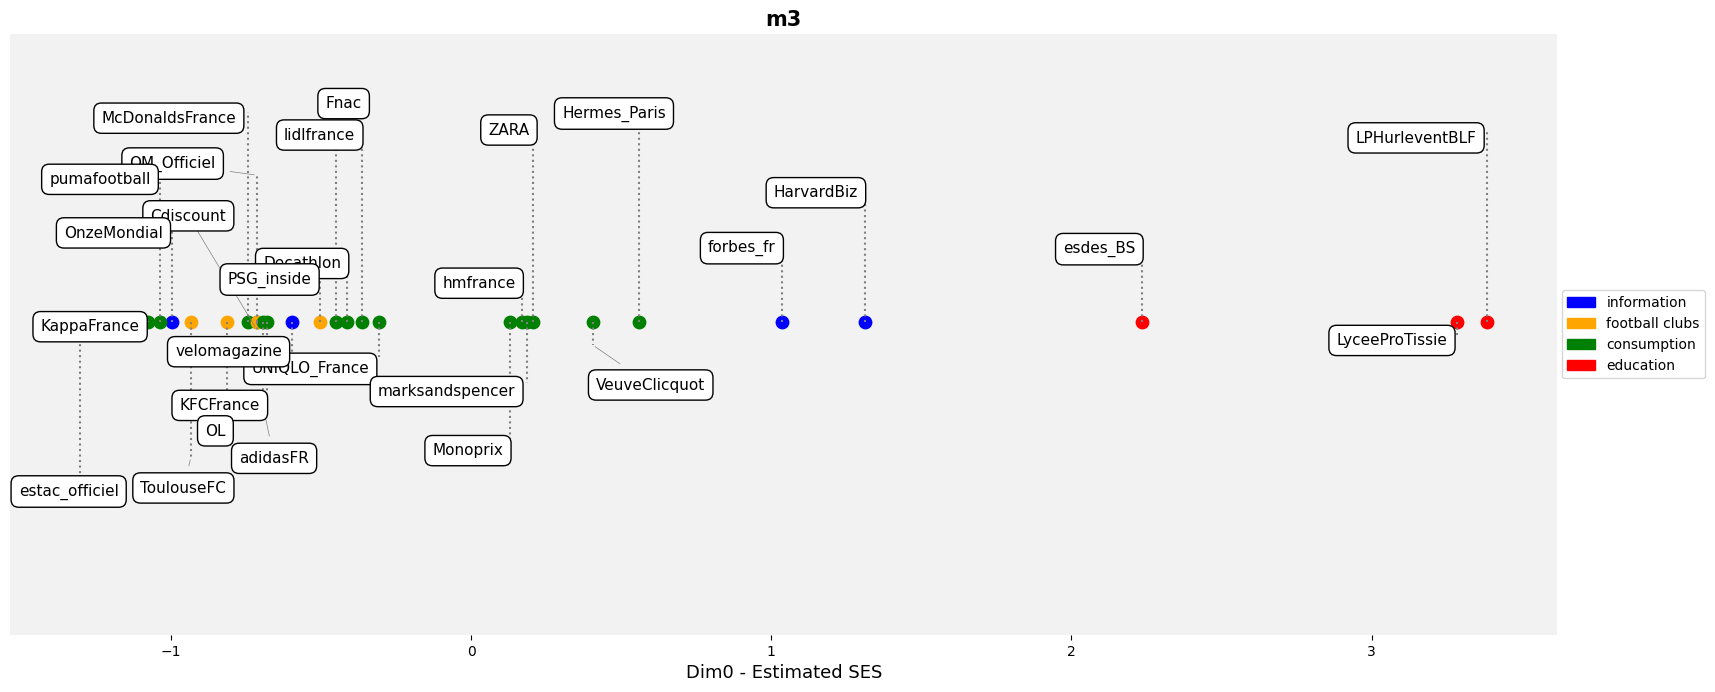

In [21]:
import matplotlib.patches as mpatches
import numpy as np
from adjustText import adjust_text
# Define the DataFrames
dfs = [marker_coords[0], marker_coords[2], marker_coords[6]]
# Define the color dictionary for 'type'
color_dict = {'information': 'blue', 'football clubs': 'orange', 'consumption': 'green', 'education': 'red'}
# Define the list of twitter_names to include
twitter_names = ['estac_officiel', 'KappaFrance', 'pumafootball', 'OnzeMondial', 'ToulouseFC', 'OnzeMondial', 'KFCFrance', 'McDonaldsFrance', 'Cdiscount', 'OM_Officiel', 'PSG_inside', 'adidasFR', 'OL', 'Fnac', 'UNIQLO_France', 'lidlfrance', 'ZARA', 'Decathlon', 'hmfrance', 'velomagazine', 'LyceeProTissie', 'LPHurleventBLF', 'ENSAEparis', 'HarvardBiz', 'esdes_BS', 'forbes_fr', 'Hermes_Paris', 'VeuveClicquot', 'Cdiscount', 'Fnac', 'lidlfrance', 'Monoprix', 'marksandspencer']
# Filter the DataFrames to include only the specified twitter_names
dfs = [df[df['twitter_name'].isin(twitter_names)] for df in dfs]
# Create a single plot
fig, ax = plt.subplots(figsize=(17, 7))
# Get the first DataFrame
df = dfs[1]
texts = []  # List to store all the text objects


# Remove the outer frame
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)


# Add a very light grey background
ax.set_facecolor((0.95, 0.95, 0.95))

# Add scatterplot for each 'twitter_name' in the DataFrame
for name in df['twitter_name'].unique():
    name_subset = df[df['twitter_name'] == name]
    type_color = color_dict[name_subset['type2'].iloc[0]]  # Get the color for the current 'type'
    scatter_points = ax.scatter(name_subset['0'], [0]*len(name_subset), color=type_color, s=80)  # Increase the size of the points

    # Add label to the plot with bigger text
    for x in name_subset['0']:
        y = np.random.uniform(-0.9, 0.9)  # Generate a random y-coordinate for the label
        text = ax.text(x, y, name, fontsize=11, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  # Increase the fontsize to a larger value
        ax.plot([x, x], [0, y], color='grey', linestyle='dotted')  # Draw a line from the scatter point to the label
        texts.append(text)

adjust_text(texts, 
            force_text=(0.06, 0.9), 
            force_static=(0.1, 0.2), 
            force_pull=(0.02, 0.01), 
            force_explode=(0.1, 0.5), 
            expand=(1.05, 1.2), 
            explode_radius="auto", 
            ensure_inside_axes=True, 
            expand_axes=True,
            arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

# Set the labels and title
ax.set_xlabel('Dim0 - Estimated SES', size=13)
ax.set_title('m3', size=15, weight =  'bold')

# Remove the values on the y-axis
ax.set_yticks([])

# Adjust y-limits for readability
ax.set_ylim(-1.3, 1.2)  # Adjust the y-limits to a smaller range

# Manually set x-limits
#ax.set_xlim(-2, 3.7)   # replace -10 and 10 with your desired min and max values

# Adjust subplot parameters
plt.subplots_adjust(bottom=0.2, top=0.8)

# Create a legend
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_dict.items()]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.1, 0.5), loc='center right')

# Show the plot
plt.tight_layout(pad = 1.0)
plt.show()

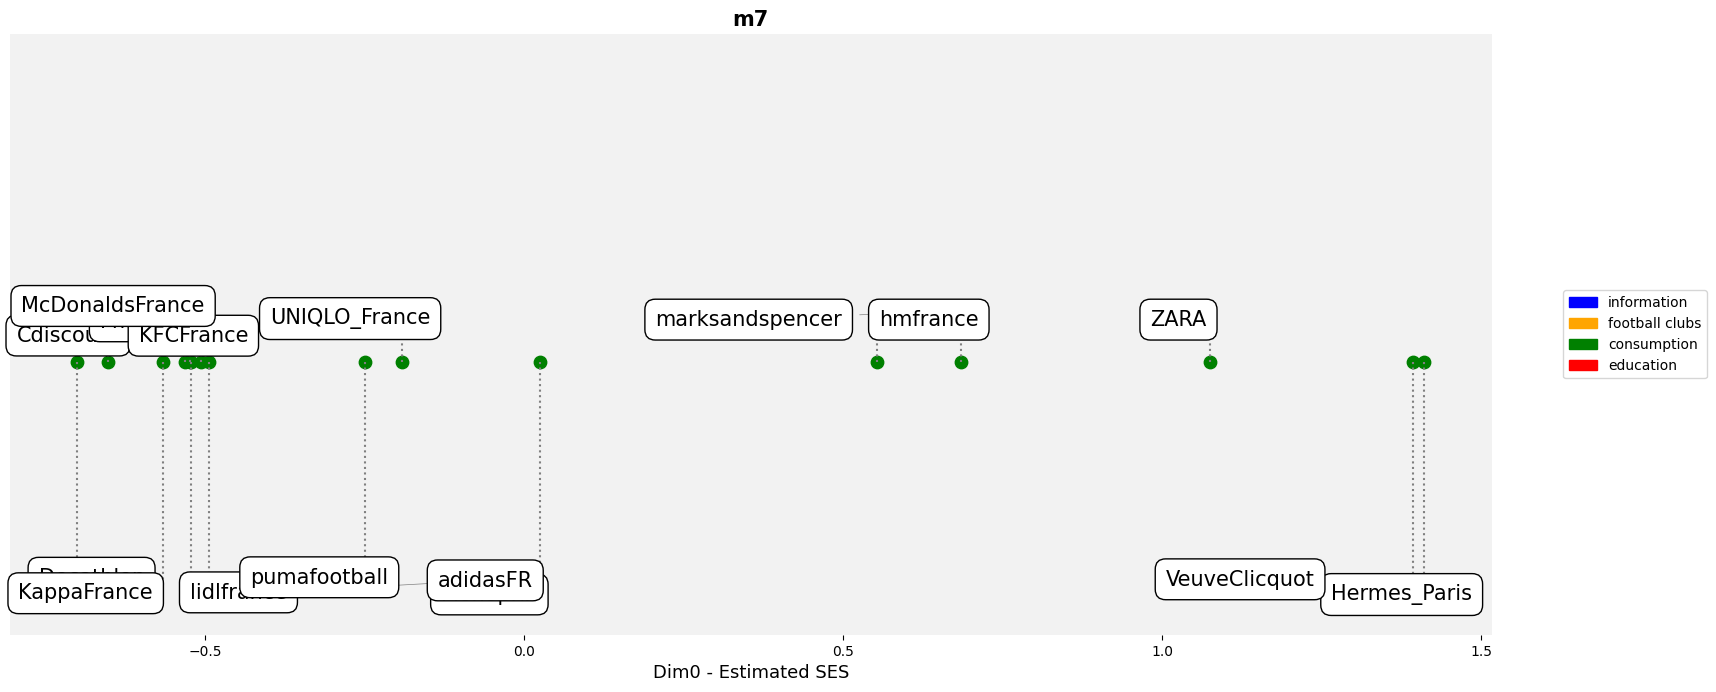

In [23]:
import matplotlib.patches as mpatches
import numpy as np
from adjustText import adjust_text

# Define the DataFrames
dfs = [marker_coords[0], marker_coords[2], marker_coords[6]]
# Define the color dictionary for 'type'
color_dict = {'information': 'blue', 'football clubs': 'orange', 'consumption': 'green', 'education': 'red'}
# Define the list of twitter_names to include
twitter_names = ['estac_officiel', 'KappaFrance', 'pumafootball', 'OnzeMondial', 'ToulouseFC', 'OnzeMondial', 'KFCFrance', 'McDonaldsFrance', 'Cdiscount', 'OM_Officiel', 'PSG_inside', 'adidasFR', 'OL', 'Fnac', 'UNIQLO_France', 'lidlfrance', 'ZARA', 'Decathlon', 'hmfrance', 'velomagazine', 'LyceeProTissie', 'LPHurleventBLF', 'ENSAEparis', 'HarvardBiz', 'esdes_BS', 'forbes_fr', 'Hermes_Paris', 'VeuveClicquot', 'Cdiscount', 'Fnac', 'lidlfrance', 'Monoprix', 'marksandspencer']
# Filter the DataFrames to include only the specified twitter_names
dfs = [df[df['twitter_name'].isin(twitter_names)] for df in dfs]
# Create a single plot
fig, ax = plt.subplots(figsize=(17, 7))
# Get the first DataFrame
df = dfs[2]
texts = []  # List to store all the text objects

# Remove the outer frame
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(False)

# Add a very light grey background
ax.set_facecolor((0.95, 0.95, 0.95))
# Add scatterplot for each 'twitter_name' in the DataFrame
for i, name in enumerate(df['twitter_name'].unique()):
    name_subset = df[df['twitter_name'] == name]
    type_color = color_dict[name_subset['type2'].iloc[0]]  # Get the color for the current 'type'
    scatter_points = ax.scatter(name_subset['0'], [0]*len(name_subset), color=type_color, s=80)  # Increase the size of the points

    # Add label to the plot with bigger text
    np.random.seed(173)  # Set a seed for the random number generator
    for x in name_subset['0']:
        # Generate a random y-coordinate for the label
        # If the index is even, place the box above the scatter point, otherwise place it below
        y = np.random.uniform(0.1, 0.9) if i % 2 == 0 else np.random.uniform(-0.9, -0.1)
        text = ax.text(x, y, name, fontsize=15, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))  # Increase the fontsize to a larger value
        ax.plot([x, x], [0, y], color='grey', linestyle='dotted')  # Draw a line from the scatter point to the label
        texts.append(text)

adjust_text(texts, 
            force_text=(0.2, 0.3), 
            force_explode=(0.8, 0.9), 
            expand=(1.05, 1.2), 
            explode_radius="auto", 
            ensure_inside_axes=True, 
            expand_axes=True,
            arrowprops=dict(arrowstyle="-", color='grey', lw=0.5))

# Set the labels and title
ax.set_xlabel('Dim0 - Estimated SES', size=13)
ax.set_title('m7', size=15, weight =  'bold')

# Remove the values on the y-axis
ax.set_yticks([])

# Adjust y-limits for readability
ax.set_ylim(-1, 1.2)  # Adjust the y-limits to a smaller range

# Manually set x-limits
#ax.set_xlim(-2, 3.7)   # replace -10 and 10 with your desired min and max values

# Adjust subplot parameters
plt.subplots_adjust(bottom=0.1, top=0.5)

# Create a legend
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in color_dict.items()]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.15, 0.5), loc='center right')

# Show the plot
plt.tight_layout(pad = 1.0)
plt.show()

In [29]:
# Create data frames with a selection of markers in the lowest, middle, and highest ranges
dfs = [marker_coords[0], marker_coords[2], marker_coords[6]]

# Create an empty list to store the modified DataFrames
modified_dfs = []

# Iterate over each DataFrame in the dfs list
for df in dfs:
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    # Add a new column 'group' that indicates whether the '0' value falls in the lowest third, middle third, or highest third
    df_copy['group'] = pd.qcut(df_copy['0'], 3, labels=['lowest', 'middle', 'highest'])
    
    # Add the modified DataFrame to the modified_dfs list
    modified_dfs.append(df_copy)

# Access the modified DataFrames
mod1 = modified_dfs[0]
mod3 = modified_dfs[1]
mod7 = modified_dfs[2]


- estac_officiel
- KappaFrance
- pumafootball
- OnzeMondial
- ToulouseFC
- OnzeMondial
- KFCFrance
- McDonaldsFrance
- Cdiscount
- OM_Officiel
- PSG_inside
- adidasFR
- OL
- Fnac
- UNIQLO_France
- lidlfrance
- ZARA
- Decathlon
- hmfrance
- velomagazine
LyceeProTissie
- LPHurleventBLF
- ENSAEparis
- HarvardBiz
- esdes_BS
- forbes_fr
- Hermes_Paris
- VeuveClicquot
- Cdiscount
- Fnac
- lidlfrance
- Monoprix
- marksandspencer


### General marker type distribution

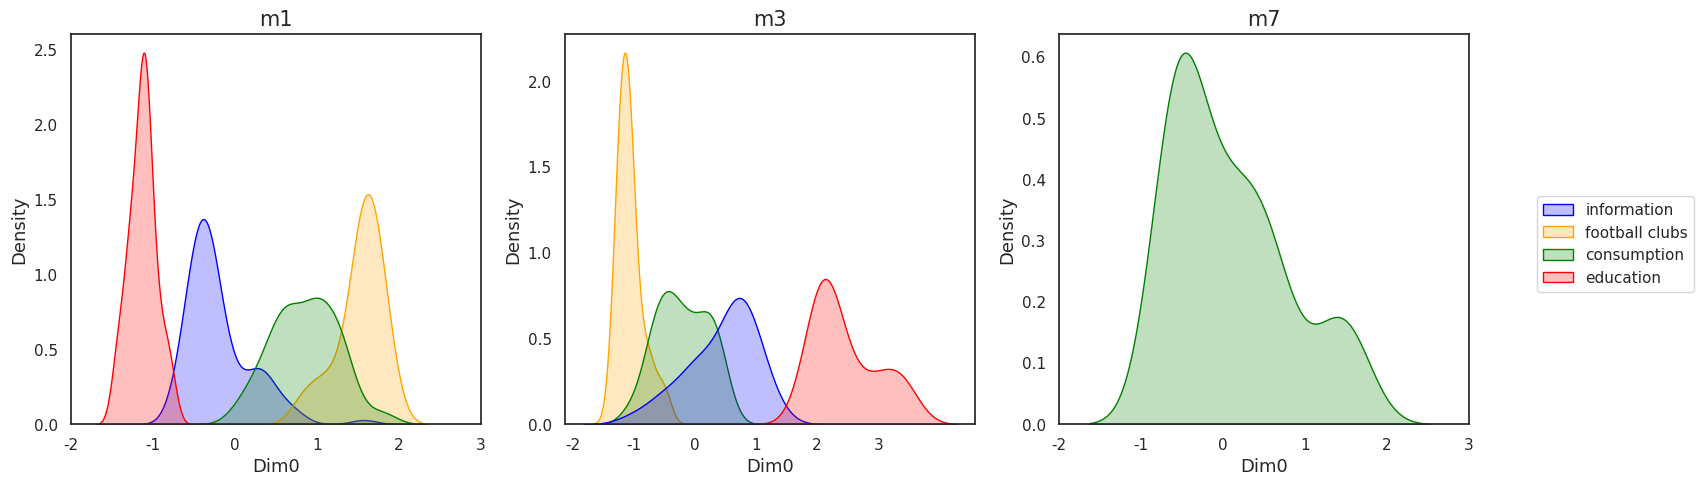

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set the style of the plot
sns.set(style="white")
# Define a color dictionary for each type
color_dict = {'information': 'blue', 'football clubs': 'orange', 'consumption': 'green', 'education': 'red'}
# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Flatten the axes array to loop over it
axs = axs.flatten()

# Create a list of the DataFrames to plot
dfs = [marker_coords[0], marker_coords[2], marker_coords[6]]
# Create a list of the DataFrame numbers
df_nums = [1, 3, 7]

# Determine the range and step for the x-axis ticks
x_ticks = range(-2, 4, 1)

# Loop over the DataFrames in dfs
for i, df in enumerate(dfs):
    # Loop over each type2 in the current DataFrame
    for type2 in df['type2'].unique():
        # Subset to the type2
        subset = df[df['type2'] == type2]
        # Draw the density plot with the color corresponding to the type on the current subplot
        sns.kdeplot(subset['0'], label = type2, fill = True, color=color_dict[type2], ax=axs[i])
    # Set the labels and title, using the corresponding DataFrame number, for the current subplot
    axs[i].set_xlabel('Dim0', size=13)
    axs[i].set_ylabel('Density', size=13)
    axs[i].set_title(f'm{df_nums[i]}', size=15)
    # Set the x-axis ticks and labels for the current subplot
    axs[i].set_xticks(x_ticks)
    axs[i].set_xticklabels(x_ticks)
# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.14, 0.5))
# Adjust the layout of the figure
plt.tight_layout()
# Adjust the main title to avoid overlap with the subplot titles
plt.subplots_adjust(top=0.92)
# Show the plot
plt.show()

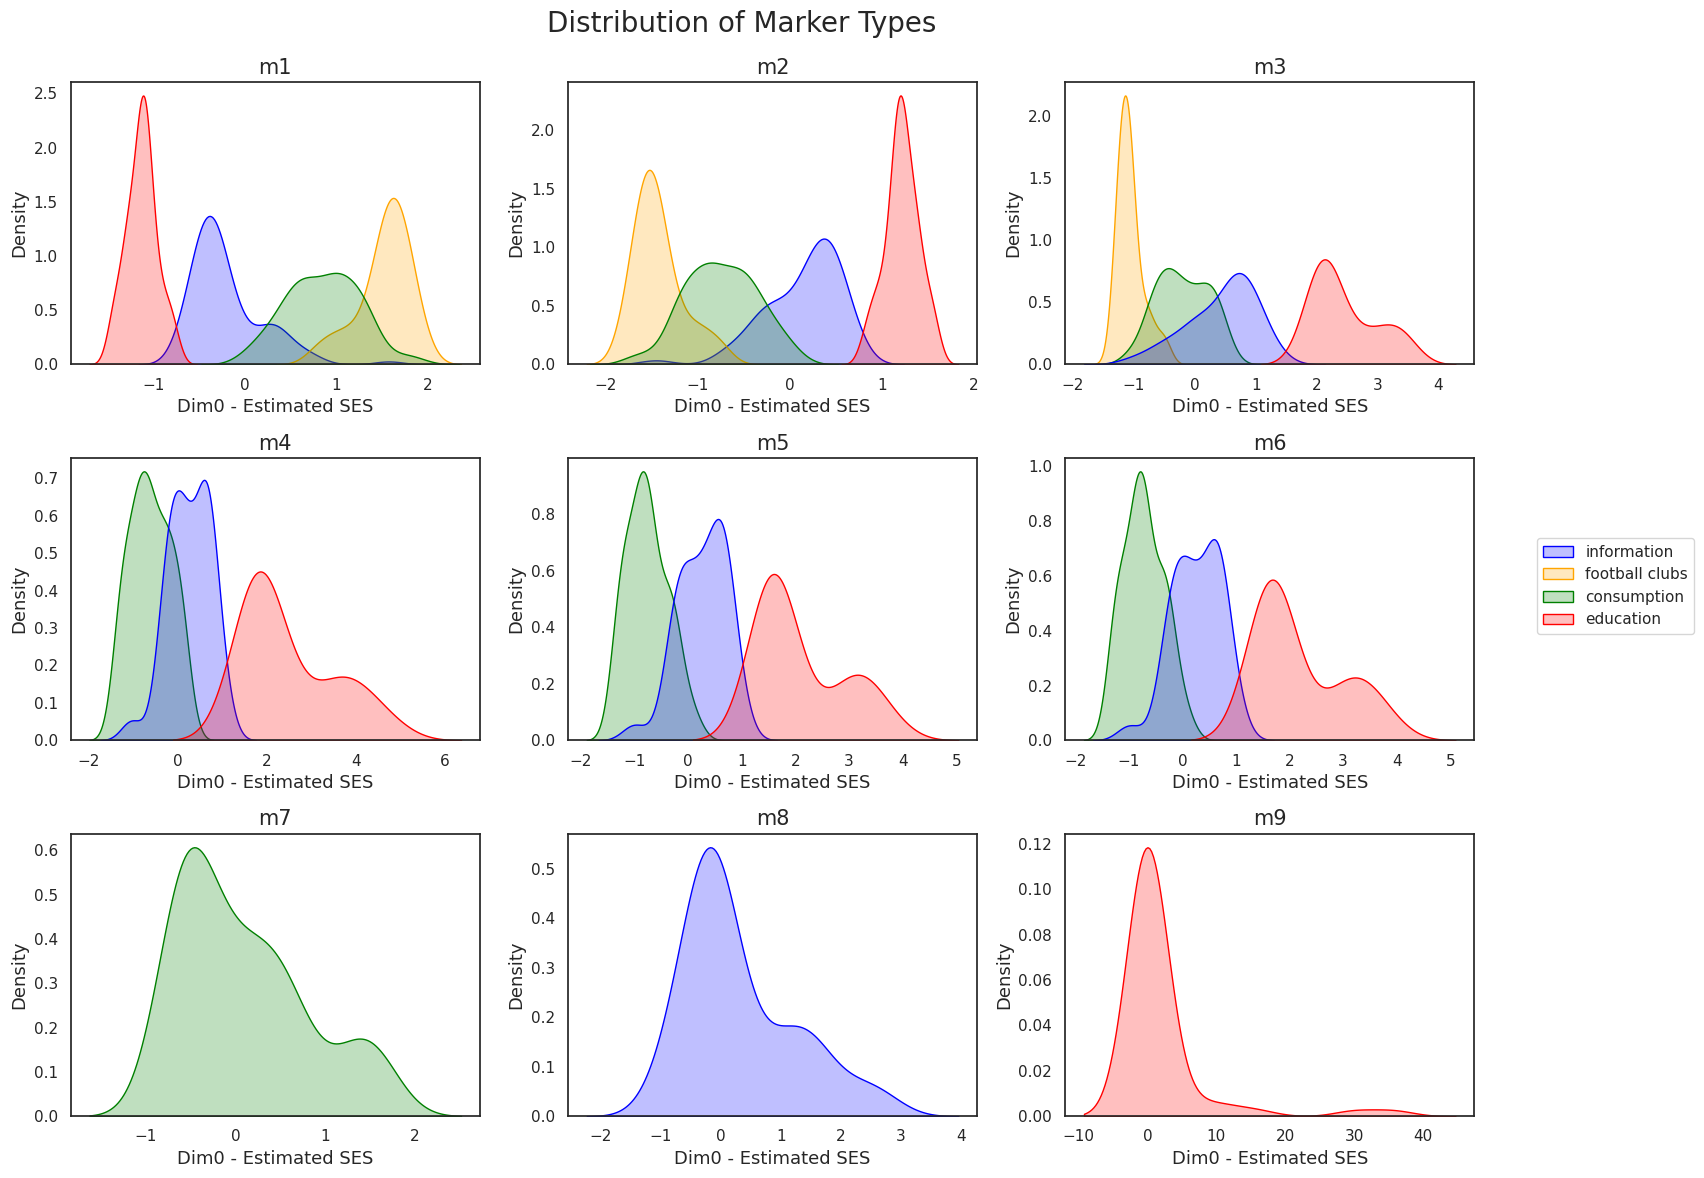

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set the style of the plot
sns.set(style="white")
# Define a color dictionary for each type
color_dict = {'information': 'blue', 'football clubs': 'orange', 'consumption': 'green', 'education': 'red'}
# Create a 3x3 grid of subplots
fig, axs = plt.subplots(3, 3, figsize=(15, 12))
# Add a main title to the figure
fig.suptitle('Distribution of Marker Types', fontsize=20)
# Flatten the axes array to loop over it
axs = axs.flatten()
# Loop over each DataFrame in marker_coords
for i in range(len(marker_coords)):
    # Loop over each type2 in the current DataFrame
    for type2 in marker_coords[i]['type2'].unique():
        # Subset to the type2
        subset = marker_coords[i][marker_coords[i]['type2'] == type2]
        # Draw the density plot with the color corresponding to the type on the current subplot
        sns.kdeplot(subset['0'], label = type2, fill = True, color=color_dict[type2], ax=axs[i])
    # Set the labels and title, including the DataFrame number, for the current subplot
    axs[i].set_xlabel('Dim0 - Estimated SES', size=13)
    axs[i].set_ylabel('Density', size=13)
    axs[i].set_title(f'm{i+1}', size=15)
# Create a single legend for the entire figure
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.14, 0.5))
# Adjust the layout of the figure
plt.tight_layout()
# Adjust the main title to avoid overlap with the subplot titles
plt.subplots_adjust(top=0.92)
# Show the plot
plt.show()


In [63]:
# Define the DataFrames
dfs = {'mod1': mod1, 'mod3': mod3, 'mod7': mod7}

# Iterate over each DataFrame
for name, df in dfs.items():
    # Filter the DataFrame to include only rows where 'type2' is 'consumption'
    df = df[df['type2'] == 'consumption']
    
    # Print the minimum and maximum values of the '0' column
    print(f"For {name}, min: {df['0'].min()}, max: {df['0'].max()}")

For mod1, min: 0.0459168726771772, max: 1.8206589952650925
For mod3, min: -1.0760274521372255, max: 0.5580278560517719
For mod7, min: -0.7008850704389102, max: 1.5899283446122048


In [64]:
# Define the DataFrames
dfs = {'mod1': mod1, 'mod3': mod3, 'mod7': mod7}

# Initialize a dictionary to store the differences
diffs = {}

# Iterate over each DataFrame
for name, df in dfs.items():
    # Filter the DataFrame to include only rows where 'type2' is 'consumption'
    df = df[df['type2'] == 'consumption']
    
    # Calculate the difference between the maximum and minimum values of the '0' column
    diff = df['0'].max() - df['0'].min()
    
    # Store the difference in the dictionary
    diffs[name] = diff

# Convert the dictionary to a DataFrame
diff_df = pd.DataFrame.from_dict(diffs, orient='index', columns=['diff'])

# Print the DataFrame
print(diff_df)

          diff
mod1  1.774742
mod3  1.634055
mod7  2.290813


### Job distribution

In [3]:
# Load the coordinate files for models 1 to 9
job_coords = utils2.load_CA_model_files(9)
job1 = job_coords[0]
job3 = job_coords[2]
job7 = job_coords[6]

Used file path: /home/livtollanes/NewData/job_title_coordinates/m1_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m2_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m3_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m4_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m5_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m6_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m7_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m8_jobs_rowcoords.csv
Used file path: /home/livtollanes/NewData/job_title_coordinates/m9_jobs_rowcoords.csv


/tmp/ipykernel_2229163/361610294.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='color', y='Salaire_moyen_en_EQTP', data=job1, palette=color_map, ax=ax, order=group_order)


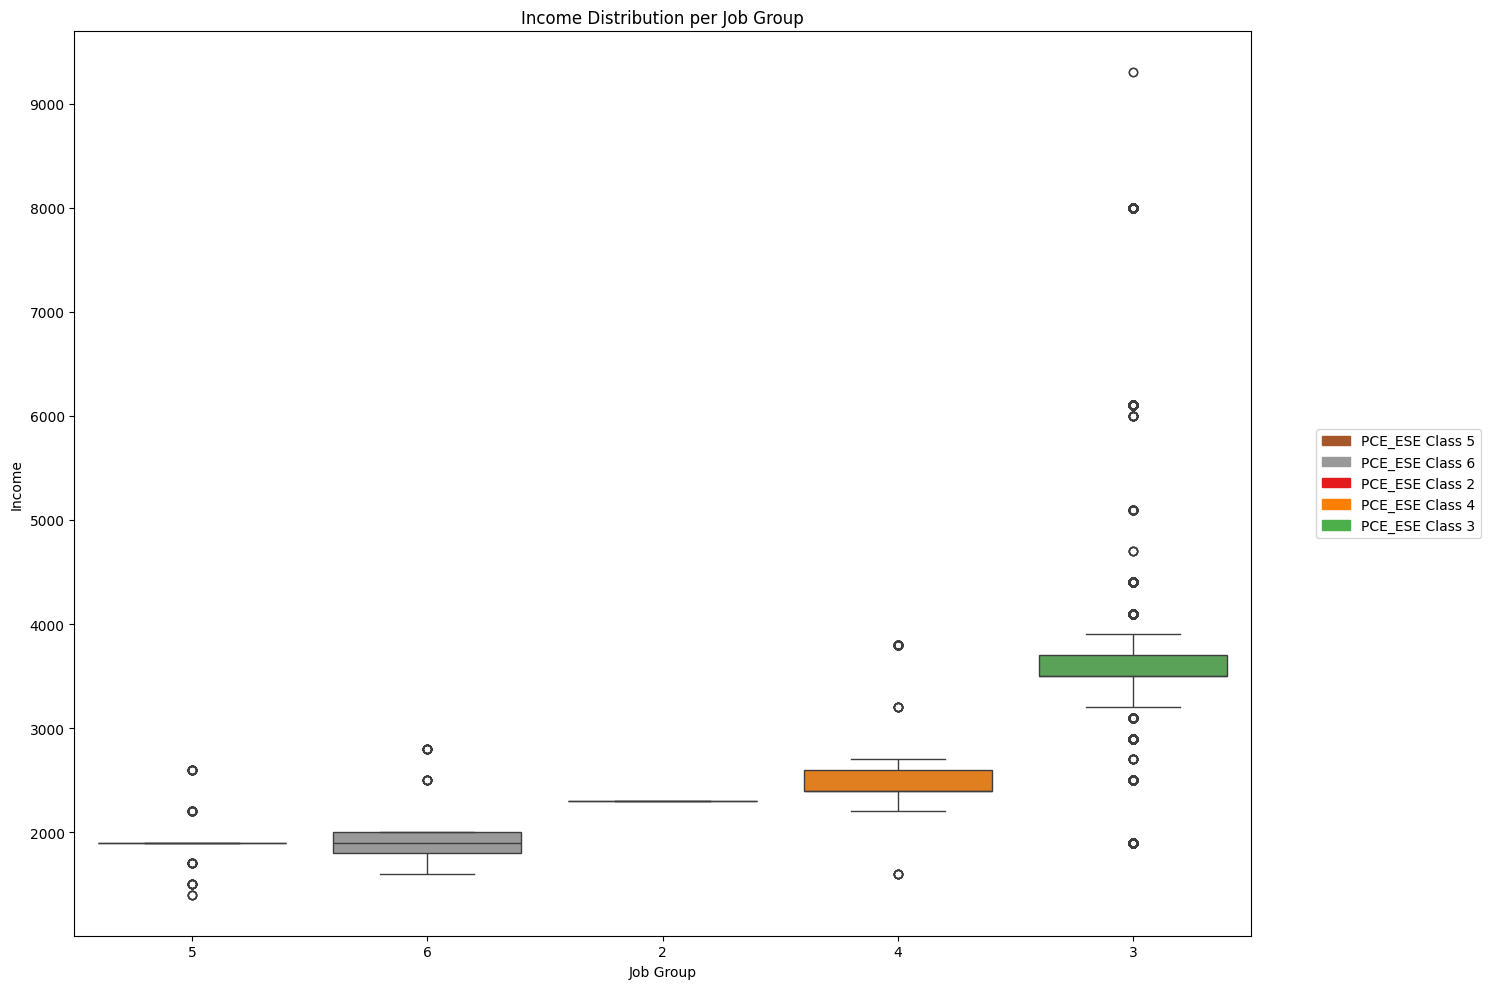

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Create color categories
job1['color'] = job1['PCS_ESE'].str[0].astype(int)

# Calculate median income for each group and sort groups by this value
group_order = df.groupby('color')['Salaire_moyen_en_EQTP'].median().sort_values().index

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

fig, ax = plt.subplots(figsize=(15, 10))

# Boxplot for each color category
sns.boxplot(x='color', y='Salaire_moyen_en_EQTP', data=job1, palette=color_map, ax=ax, order=group_order)

ax.set_title('Income Distribution per Job Group')
ax.set_xlabel('Job Group')
ax.set_ylabel('Income')

# Create custom legend handles
legend_handles = [mpatches.Patch(color=color_map[str(color)], label=f'PCE_ESE Class {color}') for color in group_order]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()
plt.show()

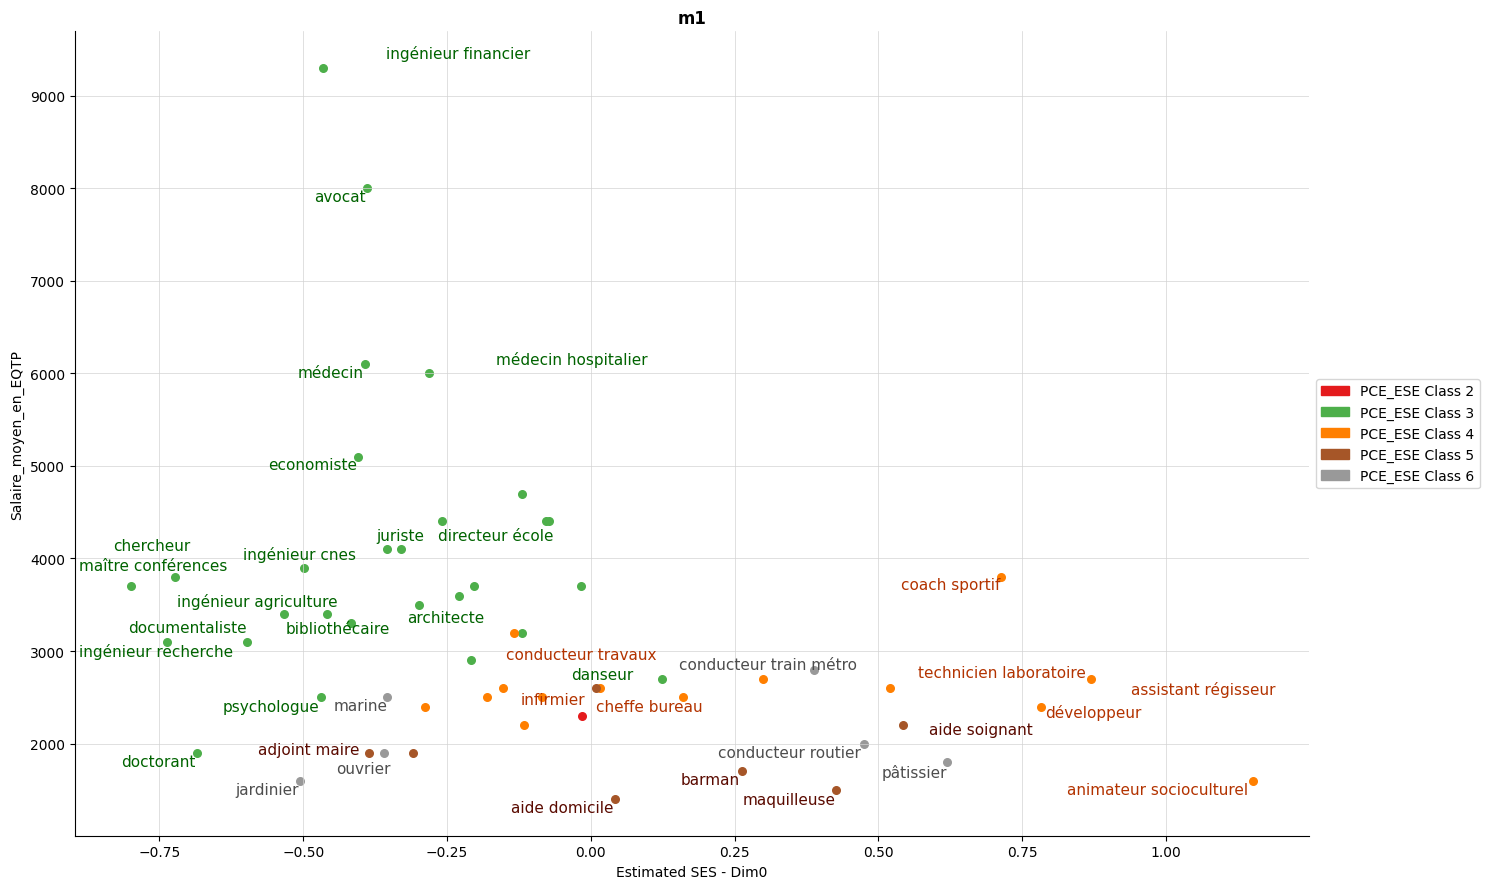

In [121]:
import matplotlib.patches as mpatches
from adjustText import adjust_text
import matplotlib.colors as mcolors

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

df = job1
outcome = 'Salaire_moyen_en_EQTP'
df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
grouped_df = df.groupby('PCS_ESE')[['0', outcome]].median()  # Grouped data
grouped_df['color'] = grouped_df.index.str[0].astype(str)
grouped_df['title'] = df.groupby('PCS_ESE')['title'].first()  # Get the title for each group

fig, ax = plt.subplots(figsize=(15, 9))

# Add a grid
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


texts = []  # List to store all the text objects

# Define thresholds for lower, middle, and upper range
lower_threshold = df['0'].quantile(0.25)  # 25th percentile
middle_threshold = df['0'].quantile(0.5)  # 50th percentile
upper_threshold = df['0'].quantile(0.75)  # 75th percentile


# Grouped data
for color in color_map.keys():
    subset = grouped_df[grouped_df['color'] == color]
    for i, point in subset.iterrows():
        ax.scatter(point['0'], point[outcome], color=color_map[color], s=30)  # Increase scatter point size
        # Add labels for points in the lower, middle, and upper range of the x-axis, for points with y-axis value greater than 5000, and for points in PCS_ESE class 4 or 5 with x-value greater than 0.5
        if (point['0'] < lower_threshold or point['0'] > upper_threshold) or (point['0'] >= lower_threshold and point['0'] <= middle_threshold) or point[outcome] > 5000 or (point['0'] > 0.5 and color in ['4', '5']):
            # Make the color of the label darker
            label_color = mcolors.to_rgb(color_map[color])
            darker_label_color = [max(0, c - 0.3) for c in label_color]
            texts.append(ax.text(point['0'], point[outcome], point['title'], fontsize=11, color=darker_label_color))  # Increase text size, add color, and add to list

ax.set_xlabel('Estimated SES - Dim0')
ax.set_ylabel(outcome)

ax.set_title('m1', weight = 'bold')
adjust_text(texts)


# Create custom legend handles
legend_handles = [mpatches.Patch(color=color_map[color], label=f'PCE_ESE Class {color}') for color in color_map.keys()]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.0, 0.5), loc='center left')

plt.tight_layout()
plt.show()

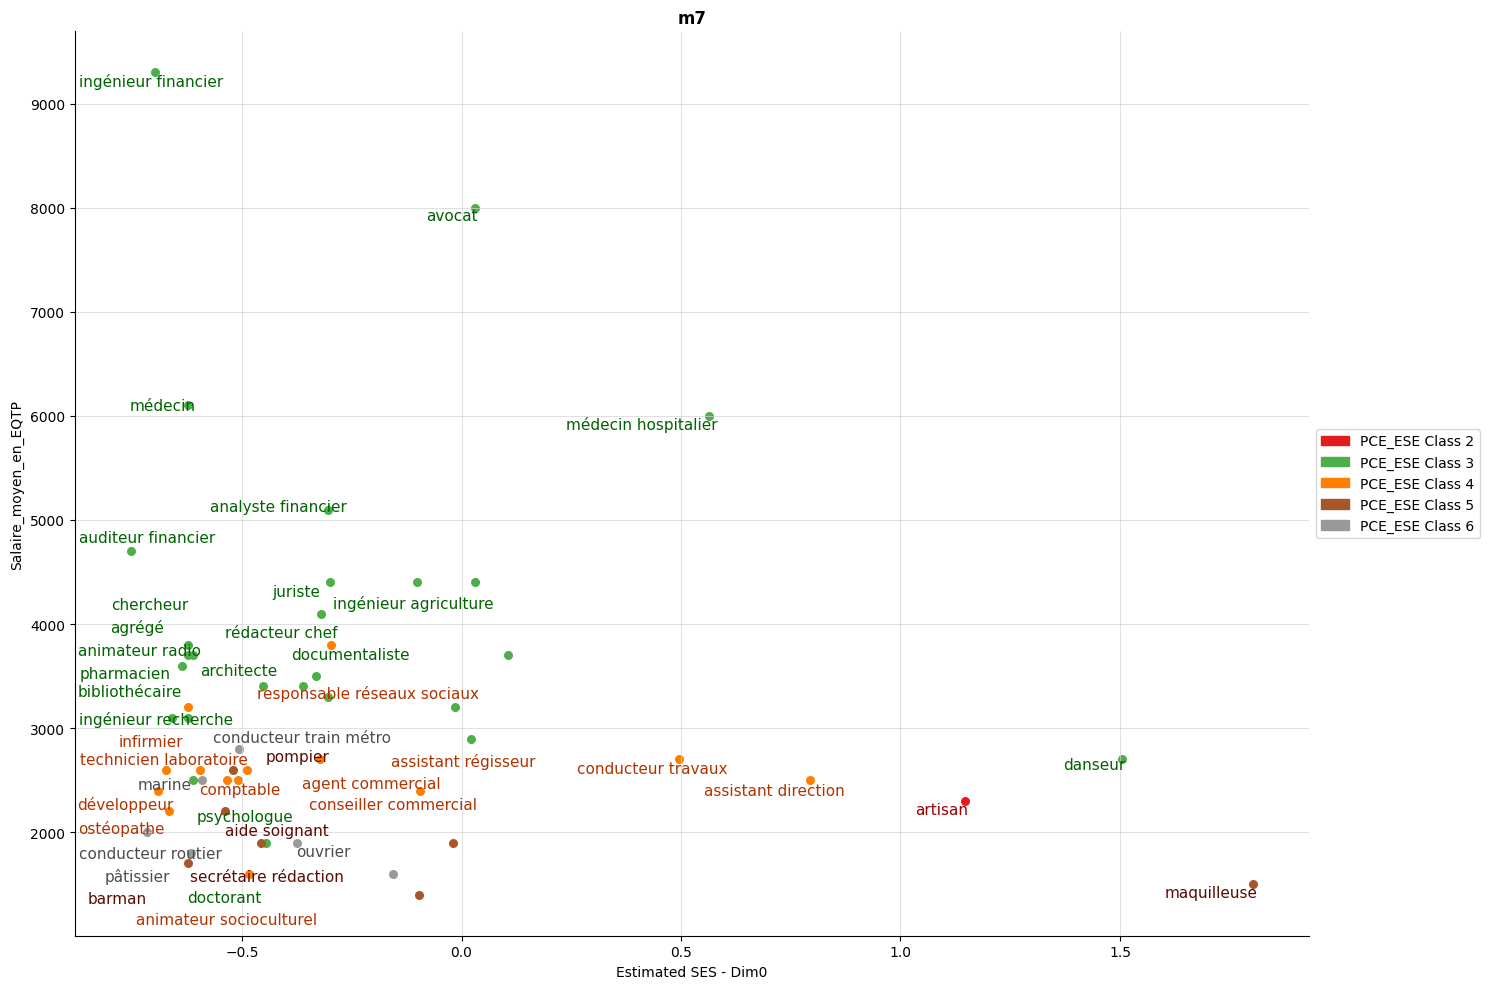

In [120]:
import matplotlib.patches as mpatches
from adjustText import adjust_text
import matplotlib.colors as mcolors

# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

df = job7
outcome = 'Salaire_moyen_en_EQTP'
df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
grouped_df = df.groupby('PCS_ESE')[['0', outcome]].median()  # Grouped data
grouped_df['color'] = grouped_df.index.str[0].astype(str)
grouped_df['title'] = df.groupby('PCS_ESE')['title'].first()  # Get the title for each group

fig, ax = plt.subplots(figsize=(15, 10))

# Add a grid
ax.grid(color='lightgrey', linestyle='-', linewidth=0.5)
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


texts = []  # List to store all the text objects

# Define thresholds for lower, middle, and upper range
lower_threshold = df['0'].quantile(0.25)  # 25th percentile
middle_threshold = df['0'].quantile(0.5)  # 50th percentile
upper_threshold = df['0'].quantile(0.75)  # 75th percentile


# Grouped data
for color in color_map.keys():
    subset = grouped_df[grouped_df['color'] == color]
    for i, point in subset.iterrows():
        ax.scatter(point['0'], point[outcome], color=color_map[color], s=30)  # Increase scatter point size
        # Add labels for points in the lower, middle, and upper range of the x-axis, for points with y-axis value greater than 5000, and for points in PCS_ESE class 4 or 5 with x-value greater than 0.5
        if point['0'] > 0.4 or (point['0'] < lower_threshold or point['0'] > upper_threshold) or (point['0'] >= lower_threshold and point['0'] <= middle_threshold) or (point[outcome] > 5000 and not (point['0'] < -0.3 and point[outcome] < 5000)) or (point['0'] > 0.5 and color in ['4', '5']):
            # Make the color of the label darker
            label_color = mcolors.to_rgb(color_map[color])
            darker_label_color = [max(0, c - 0.3) for c in label_color]
            texts.append(ax.text(point['0'], point[outcome], point['title'], fontsize=11, color=darker_label_color))  # Increase text size, add color, and add to list
ax.set_xlabel('Estimated SES - Dim0')
ax.set_ylabel(outcome)

ax.set_title('m7', weight = 'bold')
adjust_text(texts)


# Create custom legend handles
legend_handles = [mpatches.Patch(color=color_map[color], label=f'PCE_ESE Class {color}') for color in color_map.keys()]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.0, 0.5), loc='center left')

plt.tight_layout()
plt.show()

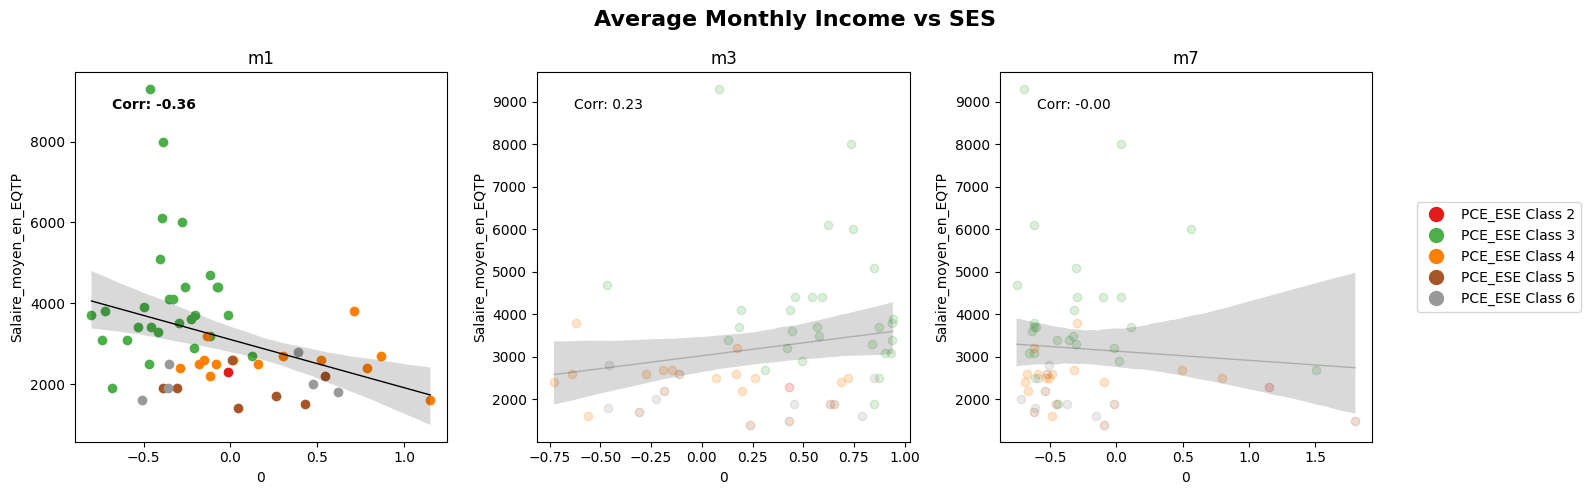

In [258]:

outcome = 'Salaire_moyen_en_EQTP'
predictors = ['0', '1', '2']
# Define a color map
color_map = {str(i): plt.cm.Set1((i-2) / 4.) for i in range(2, 7)}

# Get unique color categories
color_categories = np.unique(np.concatenate([df['PCS_ESE'].str[0].unique() for df in job_coords]))

# Create a list of the dataframes you want to plot
selected_jobs = [job_coords[0], job_coords[2], job_coords[6]]
titles = ['m1', 'm3', 'm7']  # Create a list of titles

# Create a grid of plots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))  # Adjusted subplot layout to 1 row and 3 columns

axes = axes.flatten()  # Flatten the axes array to loop over it

for i, df in enumerate(selected_jobs):
    df = df.copy()
    df['color'] = df['PCS_ESE'].str[0].astype(str)  # Ungrouped data
    grouped_df = df.groupby('PCS_ESE')[['0', outcome]].median()  # Grouped data
    grouped_df['color'] = grouped_df.index.str[0].astype(str)
    
    ax = axes[i]  # Corrected indexing here

    # Calculate correlation and adjust alpha based on it
    corr, _ = spearmanr(grouped_df['0'], grouped_df[outcome])  # Use Spearman's correlation
    alpha = 1.0 if abs(corr) >= 0.25 else 0.2  # Decrease alpha for low correlation

    # Grouped data
    for color in color_categories:
        ax.scatter(grouped_df.loc[grouped_df['color'] == color, '0'], 
                   grouped_df.loc[grouped_df['color'] == color, outcome], 
                   color=color_map[color], alpha=alpha, label=f'PCE_ESE Class {color}')
    sns.regplot(x=grouped_df['0'], y=grouped_df[outcome], 
                color='black', scatter=False, ci=95, line_kws={'linewidth': '1', 'alpha': alpha}, ax=ax)
    ax.set_xlabel('0')
    ax.set_ylabel(outcome)

    # Add correlation as text annotation
    if abs(corr) >= 0.25:
        ax.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=ax.transAxes, weight='bold')
    else:
        ax.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=ax.transAxes)
        ax.patch.set_alpha(0.3)  # Lower the alpha for other plots

    ax.set_title(titles[i])

# Create custom legend handles
legend_handles = [mlines.Line2D([], [], color=color_map[color], marker='o', linestyle='None',
                                 markersize=10, label=f'PCE_ESE Class {color}') for color in color_categories]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.1, 0.5), loc='center left')

fig.suptitle('Average Monthly Income vs SES', fontsize=16, weight='bold')

plt.tight_layout()
plt.show()

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_title_distributions(df, *titles, alpha=0.5):
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']  # Add more colors if needed

    for i, title in enumerate(titles):
        # Filter the dataframe for rows where 'title' is the current title
        df_title = df[df['title'] == title]

        # Plot the distribution of '0' for the current title
        sns.kdeplot(df_title['0'], color=colors[i % len(colors)], label=title, fill=True, alpha=alpha)

    plt.xlabel('0')
    plt.ylabel('Density')
    plt.title('Coordinate comparison for different job titles')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [280]:
# Create an empty list to store the modified DataFrames
modified_dfs = []

# Iterate over each DataFrame in the dfs list
for df in selected_jobs:
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    # Add a new column 'group' that indicates whether the '0' value falls in the lowest third, middle third, or highest third
    df_copy['group'] = pd.qcut(df_copy['0'], 3, labels=['lowest', 'middle', 'highest'])
    
    # Add the modified DataFrame to the modified_dfs list
    modified_dfs.append(df_copy)


# Iterate over each DataFrame in the modified_dfs list
for i in range(len(modified_dfs)):
    # Sort the DataFrame by the '0' column in ascending order
    modified_dfs[i] = modified_dfs[i].sort_values('0')

# Access the sorted DataFrames
mod1 = modified_dfs[0]
mod3 = modified_dfs[1]
mod7 = modified_dfs[2]


In [4]:
def lookup(df, input_value):
    # Treat all inputs as strings
    input_value = str(input_value)

    # Try to look up the PCS_ESE_name for the given PCS_ESE
    result = df[df['PCS_ESE'] == input_value]['PCS_ESE_name']

    # If no result, try to look up the PCS_ESE for the given PCS_ESE_name
    if len(result) == 0:
        result = df[df['PCS_ESE_name'] == input_value]['PCS_ESE']

    # If there are multiple matches, return the first one. If there are no matches, return None.
    return result.iloc[0] if len(result) > 0 else None

lookup(job1, 'Techniciens médicaux')

'433a'

In [36]:
def group_titles_by_PCS_ESE_name(df):
    # Group by PCS_ESE_name and apply a lambda function to get unique titles and key_words for each group
    grouped_titles = df.groupby('PCS_ESE_name')['title'].apply(lambda x: x.unique().tolist())
    grouped_key_words = df.groupby('PCS_ESE_name')['key_word'].apply(lambda x: x.unique().tolist())

    # Convert the grouped Series to a DataFrame
    df_grouped = pd.DataFrame({'PCS_ESE_name': grouped_titles.index, 'title': grouped_titles.values, 'key_word': grouped_key_words.values})

    # Export the DataFrame to a CSV file at the specified path
    df_grouped.to_csv('/home/livtollanes/NewData/professions/Overview_title_keywords.csv', index=False)

    return df_grouped

In [5]:
def plot_PCS_ESE_name_distributions(df, PCS_ESE_code_to_name, *PCS_ESE_codes, title='Coordinate comparison for different PCS_ESEs', alpha=0.5):
    # Manually specify colors
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive', 'cyan']

    # Create a new figure with a specified size (width, height)
    plt.figure(figsize=(12, 6))

    for i, PCS_ESE_code in enumerate(PCS_ESE_codes):
        # Filter the dataframe for rows where 'PCS_ESE' is the current PCS_ESE_code
        df_PCS_ESE = df[df['PCS_ESE'] == PCS_ESE_code]

        # Get the corresponding name for the current PCS_ESE_code
        PCS_ESE_name = PCS_ESE_code_to_name[PCS_ESE_code]

        # Plot the distribution of '0' for the current PCS_ESE_code
        sns.kdeplot(df_PCS_ESE['0'], color=colors[i % len(colors)], label=PCS_ESE_name, fill=True, alpha=alpha)

    plt.xlabel('Estimated SES')
    plt.ylabel('Density')
    plt.title(title, weight='bold')  # Make the title bold
    plt.legend(bbox_to_anchor=(1.3, 0.5), loc='center right', title='PCS-ESE Name')
    
    # Remove the frame around the plot
    sns.despine()
    
    plt.show()

In [36]:
lookup(job1, "Boulangers, pâtissiers (sauf activité industrielle)")

'636c'

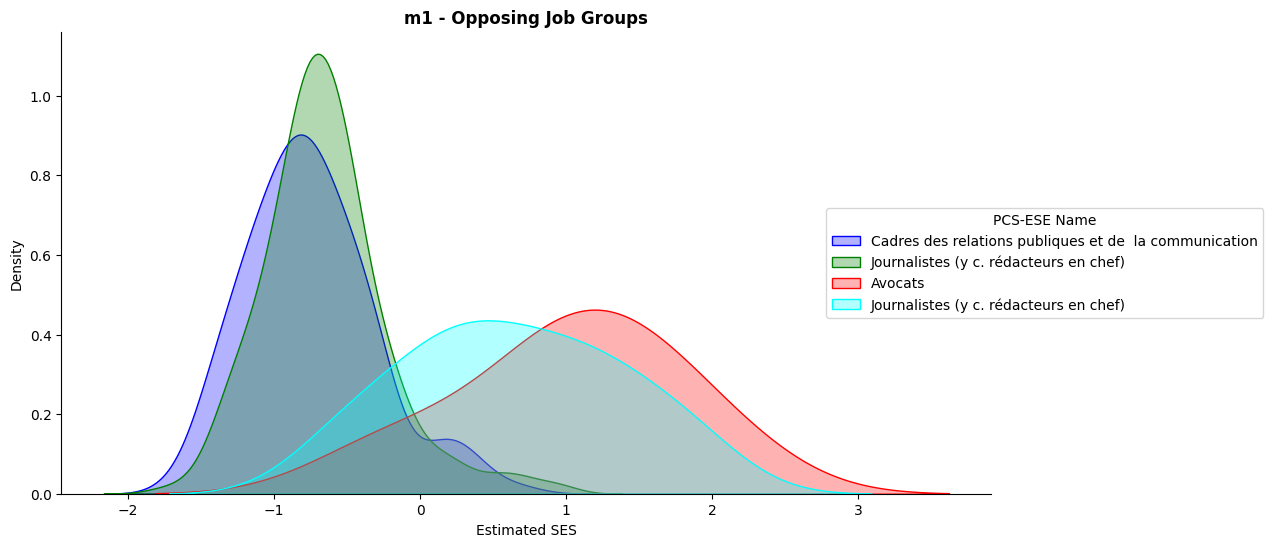

In [38]:
# Create a dictionary mapping PCS_ESE codes to names
PCS_ESE_code_to_name = dict(zip(job1['PCS_ESE'], job3['PCS_ESE_name']))

# Call the function with the PCS_ESE codes
plot_PCS_ESE_name_distributions(job1, PCS_ESE_code_to_name,'342b', '342h', '435b','636c', title= 'm1 - Opposing Job Groups', alpha=0.3)

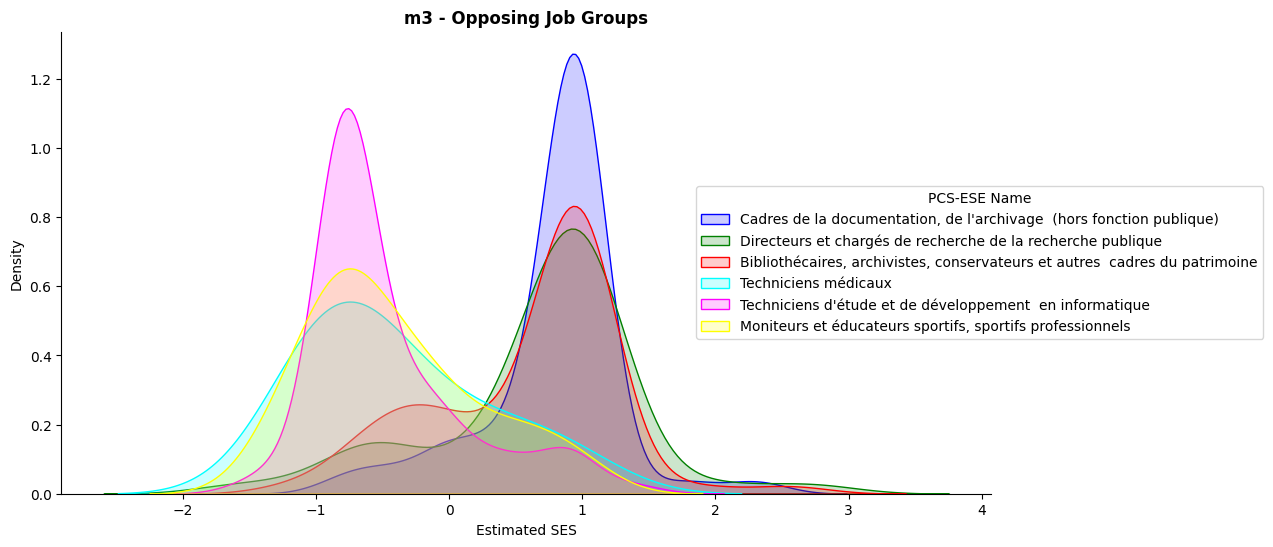

In [32]:
# Create a dictionary mapping PCS_ESE codes to names
PCS_ESE_code_to_name = dict(zip(job3['PCS_ESE'], job3['PCS_ESE_name']))

# Call the function with the PCS_ESE codes
plot_PCS_ESE_name_distributions(job3, PCS_ESE_code_to_name,'372f','342f', '351a', '433a', '478a','424a', title= 'm3 - Opposing Job Groups', alpha=0.2)

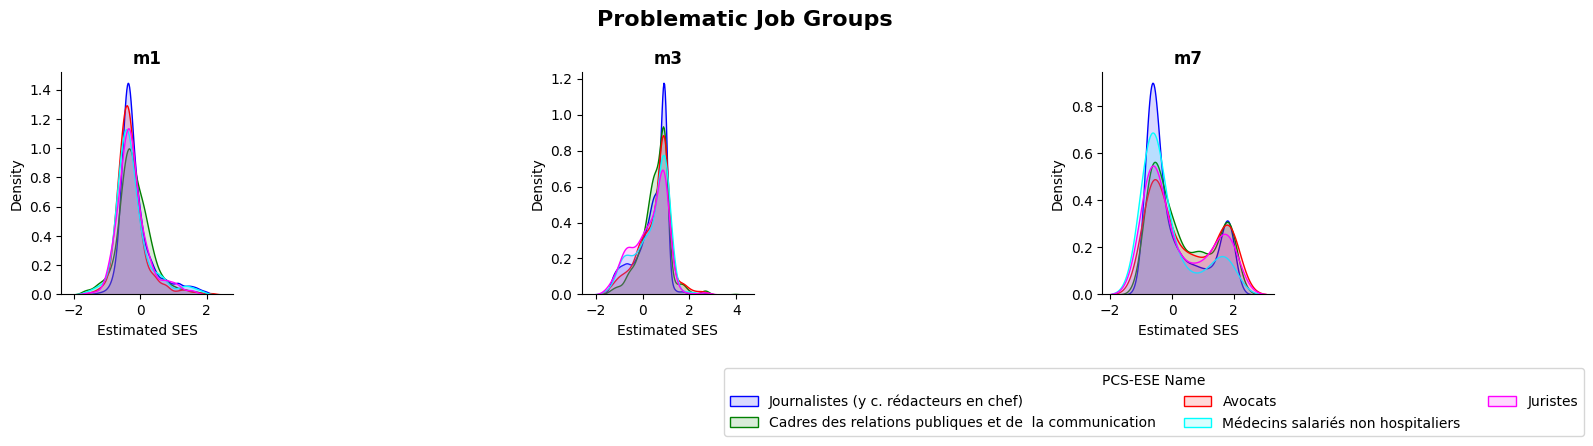

In [58]:
def plot_PCS_ESE_name_distributions(df, PCS_ESE_code_to_name, *PCS_ESE_codes, title='Coordinate comparison for different PCS_ESEs', alpha=0.5, ax=None):
    # Manually specify colors
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'pink', 'brown', 'gray', 'olive', 'cyan']

    for i, PCS_ESE_code in enumerate(PCS_ESE_codes):
        # Filter the dataframe for rows where 'PCS_ESE' is the current PCS_ESE_code
        df_PCS_ESE = df[df['PCS_ESE'] == PCS_ESE_code]

        # Get the corresponding name for the current PCS_ESE_code
        PCS_ESE_name = PCS_ESE_code_to_name[PCS_ESE_code]

        # Plot the distribution of '0' for the current PCS_ESE_code
        sns.kdeplot(df_PCS_ESE['0'], color=colors[i % len(colors)], label=PCS_ESE_name, fill=True, alpha=alpha, ax=ax)

    ax.set_xlabel('Estimated SES')
    ax.set_ylabel('Density')
    ax.set_title(title, weight='bold')  # Make the title bold
    ax.legend(bbox_to_anchor=(0.3, -0.3), loc='upper center',ncol = 3, title='PCS-ESE Name')
    
    # Remove the frame around the plot
    sns.despine()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Set the common title
fig.suptitle('Problematic Job Groups', fontsize=16, fontweight='bold')

# Define the labels and their corresponding colors
labels = ['352a', '375b', '312a', '344b', '372e']
colors = ['blue', 'green', 'red', 'cyan', 'magenta']

# Adjust the layout to make room for the legend
plt.subplots_adjust(right=0.85)

# Call the function with the PCS_ESE codes for each job
plot_PCS_ESE_name_distributions(job1, PCS_ESE_code_to_name, '352a', '375b', '312a', '344b', '372e', title='m1', alpha=0.15, ax=axs[0])
plot_PCS_ESE_name_distributions(job3, PCS_ESE_code_to_name, '352a', '375b', '312a', '344b', '372e', title='m3', alpha=0.15, ax=axs[1])
plot_PCS_ESE_name_distributions(job7, PCS_ESE_code_to_name, '352a', '375b', '312a', '344b', '372e', title='m7', alpha=0.15, ax=axs[2])

# Remove the legend for the second and third subplots
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', title='PCS-ESE Name')

AttributeError: 'NoneType' object has no attribute 'set_xlabel'

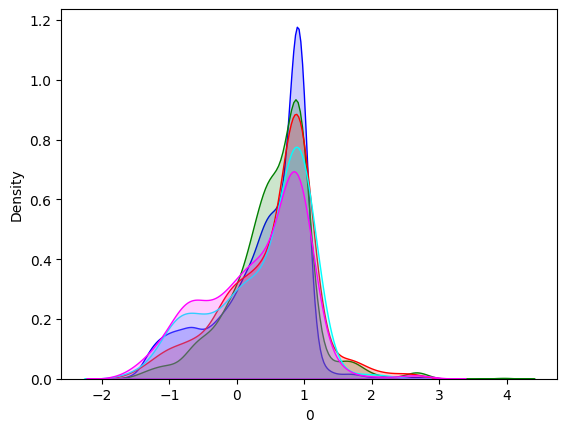

In [42]:
# Create a dictionary mapping PCS_ESE codes to names
PCS_ESE_code_to_name = dict(zip(job3['PCS_ESE'], job3['PCS_ESE_name']))

# Call the function with the PCS_ESE codes
plot_PCS_ESE_name_distributions(job3, PCS_ESE_code_to_name, '352a', '375b','312a', '344b', '372e', title= 'Problematic Job Groups - m1', alpha=0.2)

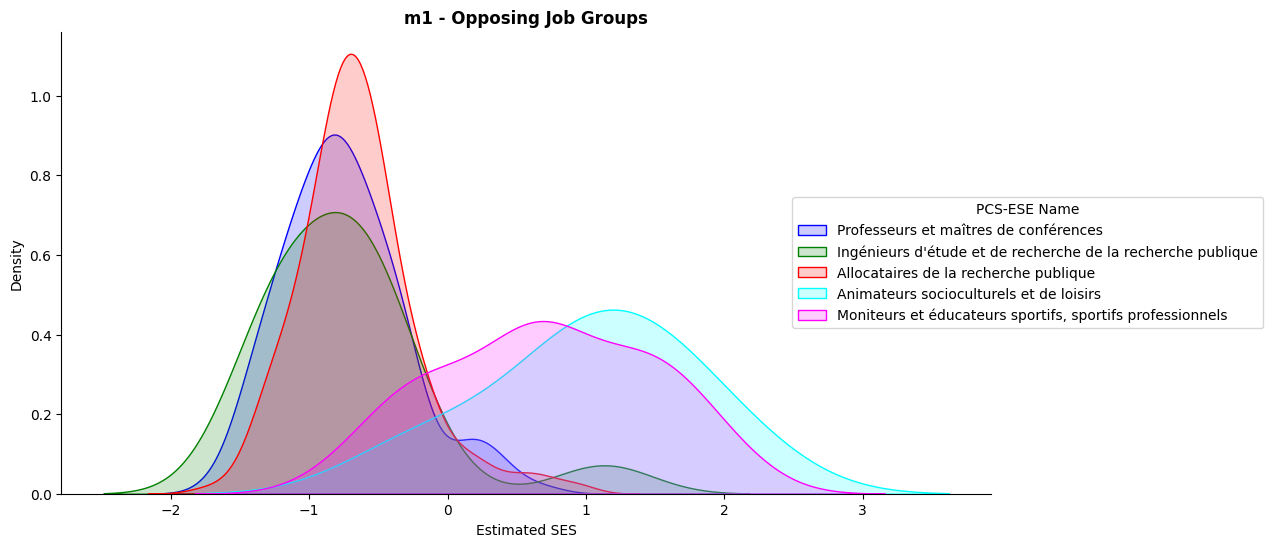

In [35]:
# Create a dictionary mapping PCS_ESE codes to names
PCS_ESE_code_to_name = dict(zip(job1['PCS_ESE'], job1['PCS_ESE_name']))

# Call the function with the PCS_ESE codes
plot_PCS_ESE_name_distributions(job1, PCS_ESE_code_to_name,'342b', '342g', '342h','435b', '424a', title= 'm1 - Opposing Job Groups', alpha=0.2)

In [36]:
# Get the 10 biggest PCS_ESE_name groups
top_10_PCS_ESE_name = job1['PCS_ESE_name'].value_counts().head(10)

print("Top 10 PCS_ESE_name groups:")
print(top_10_PCS_ESE_name)

Top 10 PCS_ESE_name groups:
PCS_ESE_name
Journalistes (y c. rédacteurs en chef)                      6615
Cadres des relations publiques et de  la communication       897
Avocats                                                      617
Artistes de la musique et du chant                           355
Adjoints administratifs des collectivités locales            347
Juristes                                                     330
Allocataires de la recherche publique                        273
Artistes plasticiens                                         198
Médecins salariés non hospitaliers                           185
Techniciens d'étude et de développement  en informatique     165
Name: count, dtype: int64


In [39]:
# Define the PCS_ESE_name groups
PCS_ESE_names = ['Journalistes (y c. rédacteurs en chef)', 'Avocats', 'Juristes', 'Médecins salariés non hospitaliers']

for name in PCS_ESE_names:
    # Filter the DataFrame for the current PCS_ESE_name group
    filtered_df = job1[job1['PCS_ESE_name'] == name]

    # Get the minimum and maximum of column '0'
    min_value = filtered_df['0'].min()
    max_value = filtered_df['0'].max()

    print(f"PCS_ESE_name: {name}")
    print(f"Minimum value of column '0': {min_value}")
    print(f"Maximum value of column '0': {max_value}\n")

PCS_ESE_name: Journalistes (y c. rédacteurs en chef)
Minimum value of column '0': -1.6045685487080728
Maximum value of column '0': 2.092969166349113

PCS_ESE_name: Avocats
Minimum value of column '0': -1.5415311820396778
Maximum value of column '0': 2.183513733044806

PCS_ESE_name: Juristes
Minimum value of column '0': -1.629058280076242
Maximum value of column '0': 1.5898311723485354

PCS_ESE_name: Médecins salariés non hospitaliers
Minimum value of column '0': -1.5910951605654031
Maximum value of column '0': 1.7684880917682744



In [42]:
print(job1['0'].min())
print(job1['0'].max())

-1.7554798008620711
2.183513733044806


In [6]:
# Calculate median score per title and sort from highest to lowest
median_scores = job1.groupby('PCS_ESE_name')['0'].median().sort_values(ascending=False)

pd.set_option('display.max_rows', None)
# Print the sorted median scores
print(median_scores)

#animateur périscolaire, tennis coach, animateur sportif, développeur, danseur, aide soignant, infirmier, professeur universités, doctorant, jardinier, psychologue, barmaid, pharmacien

PCS_ESE_name
Animateurs socioculturels et de loisirs                                                          1.151056
Assistants techniques de la réalisation des spectacles  vivants et audiovisuels                  0.869521
Techniciens d'étude et de développement  en informatique                                         0.783552
Moniteurs et éducateurs sportifs, sportifs professionnels                                        0.713735
Boulangers, pâtissiers (sauf activité industrielle)                                              0.620145
Aides-soignants                                                                                  0.542415
Techniciens médicaux                                                                             0.520787
Conducteurs routiers et grands routiers                                                          0.474362
Manucures, esthéticiens                                                                          0.427229
Conducteurs qualifiés d'engins de

In [8]:
# Calculate median score per title and sort from highest to lowest
median_scores = job7.groupby('title')['0'].median().sort_values(ascending=False)

pd.set_option('display.max_rows', None)
# Print the sorted median scores
print(median_scores)

#animateur périscolaire, tennis coach, animateur sportif, développeur, danseur, aide soignant, infirmier, professeur universités, doctorant, jardinier, psychologue, barmaid, pharmacien

title
manucure                          1.839216
maquilleuse                       1.789933
sculpteur                         1.775816
esthéticienne                     1.761676
danseur                           1.505180
artiste plasticien                1.453826
chargée relations                 1.372885
responsable affaires publiques    1.337506
artisan                           1.147343
coiffeur                          1.091467
artiste                           0.911688
assistant direction               0.794880
cheffe bureau                     0.679580
auteur compositeur interprète     0.667340
agrégé                            0.615335
auteur compositeur                0.610323
médecin hospitalier               0.564196
barista                           0.561533
acteur                            0.550876
directrice communication          0.520718
conducteur travaux                0.495449
illustrateur                      0.446776
analyste financier                0.376979
rappe

In [49]:
lookup(job1, "Avocats")

'312a'

### Inspection of extreme ends

In [53]:
# Filter the DataFrame for PCS_ESE == 352a
df_352a = job1[job1['PCS_ESE'] == '344b']

# Sort the DataFrame by column '0' in ascending order
df_352a_sorted = df_352a.sort_values(by='0', ascending=True)

# Get the top 10 rows
top_10 = df_352a_sorted.head(10)

# Get the bottom 10 rows
bottom_10 = df_352a_sorted.tail(10)

# Get the middle 10 rows
middle_index = df_352a_sorted.shape[0] // 2
middle_10 = df_352a_sorted.iloc[middle_index - 5: middle_index + 5]

pd.set_option('display.max_colwidth', None)
# Merge the top 10, bottom 10, and middle 10 rows into one DataFrame

# Add a new column to indicate whether the rows are from the top, middle, or bottom
top_10['Position'] = 'Top'
middle_10['Position'] = 'Middle'
bottom_10['Position'] = 'Bottom'
merged_df = pd.concat([top_10, middle_10, bottom_10])
# Select the specified columns
selected_columns = merged_df[['0', 'screen_name', 'description_cleantext', 'PCS_ESE_name', 'PCS_ESE', 'title', 'Position']]

selected_columns



/tmp/ipykernel_2263908/2851427954.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['Position'] = 'Top'
/tmp/ipykernel_2263908/2851427954.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle_10['Position'] = 'Middle'
/tmp/ipykernel_2263908/2851427954.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,0,screen_name,description_cleantext,PCS_ESE_name,PCS_ESE,title,Position
516,-1.591095,StoffelMarine,externe en médecine @unistra,Médecins salariés non hospitaliers,344b,médecin,Top
10105,-1.409309,pr_gignon,#Médecin PUPH santé publique prévention formation Professeur de #santé publique conseiller Santé #étudiants #ESR Compte perso #RT n’est pas approbation,Médecins salariés non hospitaliers,344b,médecin,Top
10861,-1.243966,isabelle_gremy,"médecin épidémiologiste-intéressée par la santé publique, la réduction des inégalités de santé, la santé dans toutes les politiques....tweets are my own.",Médecins salariés non hospitaliers,344b,médecin,Top
10224,-1.228463,wanda_yekhlef,Médecin Pôle CRISTALES @EPSVilleEvrard #Soinssomatiques #Préventions #SantéPublique #Addictions #Hypnoanalgésie #handicap #autisme #DEFI #psychiatrie @ANP3SM,Médecins salariés non hospitaliers,344b,médecin,Top
5222,-1.172441,jpcanevet,"Médecin generaliste retraité & professeur associé de MG retraité. Intérêt pour la recherche transdisciplinaire en MGassociation ""La santé à voix haute""",Médecins salariés non hospitaliers,344b,médecin,Top
9555,-1.114061,FarsiFadila,"médecin, directrice du dispositif spécifique régional de cancérologie ONCO AURA #cancer #RRC #santé #clinicalguidelines #esante opinions are my own",Médecins salariés non hospitaliers,344b,médecin,Top
11361,-0.928083,doccadam,"Médecin généraliste #merignac #bordeaux militant, prof associé @univbordeaux médecin coordonnateur #samsah @sos_solidarites Mes tweets n'engagent que moi !",Médecins salariés non hospitaliers,344b,médecin,Top
10943,-0.880055,Godthorax,"Médecin néphrologue, formé @APHM_actu, @UPJV_Univ. Master en biologie de la santé @univamu.",Médecins salariés non hospitaliers,344b,médecin,Top
11496,-0.847973,Jmben58,Médecin. Education populaire en santé tout au long de la vie (MMC). Coordonnateur du partenariat de soin avec les patients et le public (CI3P),Médecins salariés non hospitaliers,344b,médecin,Top
2663,-0.806413,ANNEGAGNEPAIN,Médecin de santé publiqueDéléguée Générale @assogfaop Membre honoraire @worldSIOP Dr Honoris Causa @MedicinaUNA,Médecins salariés non hospitaliers,344b,médecin,Top


In [54]:
# Filter the DataFrame for PCS_ESE == 352a
df_352a = job1[job1['PCS_ESE'] == '372e']

# Sort the DataFrame by column '0' in ascending order
df_352a_sorted = df_352a.sort_values(by='0', ascending=True)

# Get the top 10 rows
top_10 = df_352a_sorted.head(10)

# Get the bottom 10 rows
bottom_10 = df_352a_sorted.tail(10)

# Get the middle 10 rows
middle_index = df_352a_sorted.shape[0] // 2
middle_10 = df_352a_sorted.iloc[middle_index - 5: middle_index + 5]

pd.set_option('display.max_colwidth', None)
# Merge the top 10, bottom 10, and middle 10 rows into one DataFrame

# Add a new column to indicate whether the rows are from the top, middle, or bottom
top_10['Position'] = 'Top'
middle_10['Position'] = 'Middle'
bottom_10['Position'] = 'Bottom'
merged_df = pd.concat([top_10, middle_10, bottom_10])
# Select the specified columns
selected_columns = merged_df[['0', 'screen_name', 'description_cleantext', 'PCS_ESE_name', 'PCS_ESE', 'title', 'Position']]

selected_columns



/tmp/ipykernel_2263908/2697956258.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['Position'] = 'Top'
/tmp/ipykernel_2263908/2697956258.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  middle_10['Position'] = 'Middle'
/tmp/ipykernel_2263908/2697956258.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

,0,screen_name,description_cleantext,PCS_ESE_name,PCS_ESE,title,Position
1409,-1.629058,ValerieTNeykova,Juriste Business Affairs Master 2 Management des télécoms et des médias à @Paris_Dauphine Ancienne élue CFVU et UFR 2/3e cycle d’@AssasParis2,Juristes,372e,juriste,Top
4795,-1.405914,DJCECergy,Diplôme juriste conseil d'entreprise - #UCP FB: http://facebook.com/DJCE.Cergy.Pon... Insta : http://Instagram.com/djcecergy,Juristes,372e,juriste,Top
4412,-1.289330,JeremiePDE,Juriste Relations Sociales au sein de la Caisse Régionale Crédit Agricole Val de France,Juristes,372e,juriste,Top
6002,-1.099981,Abdemy5,Juriste NTICDroit du Numérique #RGPD #IA #cyber,Juristes,372e,juriste,Top
10796,-1.049013,escande_david,#RH & Juriste #DroitSocial - Tweete aussi parfois sur #Astronomie #Hamradio #Unix ...pour le plaisir de partager.,Juristes,372e,juriste,Top
1070,-1.005834,adeline__j,Juriste Droit des nouvelles technologies DPO,Juristes,372e,juriste,Top
2648,-0.967922,barbaratiriou,juriste droit du travail - égalité Femmes-Hommes,Juristes,372e,juriste,Top
8330,-0.965638,DoThirry,Juriste spécialisée droit de la santé & Coach professionnel certifiée #patients #aidants #vulnérabilité Fondatrice @JurisSante déploiement-#LabAgora,Juristes,372e,juriste,Top
2224,-0.960031,RamachandraOS,"Juriste d’affaires @M214Dauphine Passé par @AssembleeNat, cab @lesoutremer et Henri IV Droit, Justice, économie, littérature, Outre-mer",Juristes,372e,juriste,Top
2088,-0.947801,Katia__F,Alsacienne délocalisée à Paris - #juriste #droitpublic #fonctionpublique,Juristes,372e,juriste,Top
